In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import entropy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from strategy import *
from learner import *

# Data preprocessing

### Loading and visualizing

In [3]:
def print_shapes(*args, **kwargs):
    for i in args:
        print(i.shape)
    for i in kwargs.keys():
        print(kwargs[i].shape)

def print_all(*args, **kwargs):
    for i in args:
        print(i)
    for i in kwargs.keys():
        print(kwargs[i])

In [4]:
data = datasets.load_digits()

In [5]:
data.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [6]:
print_shapes(data['data'], data['target'], data['target_names'], data['images'])

(1797, 64)
(1797,)
(10,)
(1797, 8, 8)


In [7]:
data['target_names']

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

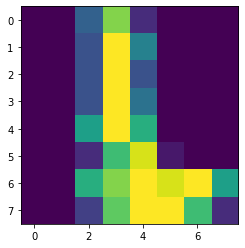

In [8]:
plt.imshow(data['data'][np.random.randint(0, 1000)].reshape(8,8))

### Splitting the data|

In [9]:
X, y = data['data'], data['target']

In [10]:
x_train, x_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.1, random_state=42, shuffle=True, stratify=y)

In [11]:
print_shapes(x_train, x_val, y_train, y_val)

(1617, 64)
(180, 64)
(1617,)
(180,)


In [12]:
# Now splitting into labelled and unlabelled data for purposes of active learning

In [13]:
x_labelled, x_unlabelled, y_labelled, y_unlabelled = train_test_split(
                                                    x_train, y_train, test_size=0.99, random_state=42, stratify=y_train)

x = object()
y = object()

train = {x: x_labelled, y: y_labelled}
stream = {x: x_unlabelled, y: y_unlabelled}

# Making the Model

## Uncertainty sampling

In [14]:
stream_list = [(stream[x][i][None, :], stream[y][i][None]) for i in range(stream[x].shape[0])]

model = [RandomForestClassifier()]
strategy = uncertainty_sampling
stream_iter = iter(stream_list)

learner = ActiveLearner(model, strategy='uncertainity', uncertainity_measure='lc')

In [15]:
learner.teach(train[x], train[y])

/Users/akash/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [16]:
learner.score(x_val, y_val)

0.39444444444444443

In [17]:
num_iters = 0
num_samples_taken = 0
score = learner.score(x_val, y_val)
while score < 0.95:
    print(f"Iteration: {num_iters}\t Score: {score}")
    for i in range(5):
        num_iters += 1
        inp, target = next(stream_iter)
        if learner.query(inp):
            num_samples_taken += 1
            learner.teach(inp, target)
    score = learner.score(x_val, y_val)
print(f"FINAL Iteration: {num_iters}\t Score: {score}\t New Samples Taken: {num_samples_taken}")

Iteration: 0	 Score: 0.39444444444444443
Iteration: 5	 Score: 0.4666666666666667
Iteration: 10	 Score: 0.43333333333333335
Iteration: 15	 Score: 0.4111111111111111
Iteration: 20	 Score: 0.5166666666666667
Iteration: 25	 Score: 0.5722222222222222
Iteration: 30	 Score: 0.6
Iteration: 35	 Score: 0.5555555555555556
Iteration: 40	 Score: 0.5888888888888889
Iteration: 45	 Score: 0.6611111111111111
Iteration: 50	 Score: 0.6388888888888888
Iteration: 55	 Score: 0.5944444444444444
Iteration: 60	 Score: 0.6833333333333333
Iteration: 65	 Score: 0.6111111111111112
Iteration: 70	 Score: 0.6666666666666666
Iteration: 75	 Score: 0.7166666666666667
Iteration: 80	 Score: 0.7166666666666667
Iteration: 85	 Score: 0.7222222222222222
Iteration: 90	 Score: 0.75
Iteration: 95	 Score: 0.7944444444444444
Iteration: 100	 Score: 0.7555555555555555
Iteration: 105	 Score: 0.7055555555555556
Iteration: 110	 Score: 0.6777777777777778
Iteration: 115	 Score: 0.7722222222222223
Iteration: 120	 Score: 0.7111111111111111

Iteration: 1030	 Score: 0.9055555555555556
Iteration: 1035	 Score: 0.9111111111111111
Iteration: 1040	 Score: 0.9277777777777778
Iteration: 1045	 Score: 0.9277777777777778
Iteration: 1050	 Score: 0.9333333333333333
Iteration: 1055	 Score: 0.9333333333333333
Iteration: 1060	 Score: 0.8888888888888888
Iteration: 1065	 Score: 0.8888888888888888
Iteration: 1070	 Score: 0.9055555555555556
Iteration: 1075	 Score: 0.8944444444444445
Iteration: 1080	 Score: 0.8944444444444445
Iteration: 1085	 Score: 0.9055555555555556
Iteration: 1090	 Score: 0.8944444444444445
Iteration: 1095	 Score: 0.8944444444444445
Iteration: 1100	 Score: 0.8944444444444445
Iteration: 1105	 Score: 0.9166666666666666
Iteration: 1110	 Score: 0.9222222222222223
Iteration: 1115	 Score: 0.9277777777777778
Iteration: 1120	 Score: 0.9277777777777778
Iteration: 1125	 Score: 0.9333333333333333
Iteration: 1130	 Score: 0.9333333333333333
Iteration: 1135	 Score: 0.9055555555555556
FINAL Iteration: 1140	 Score: 0.95	 New Samples Taken:

## Query by committee

#### Experiments

In [30]:
a = np.array([[0.6666, 0.3333, 0.0], [0.0, 0.6666, 0.3333], [0.3333, 0.3333, 0.3333],
      [0.0   , 0.0   , 1.0   ],
      [0.0   , 0.3333, 0.6666]])

In [31]:
a

array([[0.6666, 0.3333, 0.    ],
       [0.    , 0.6666, 0.3333],
       [0.3333, 0.3333, 0.3333],
       [0.    , 0.    , 1.    ],
       [0.    , 0.3333, 0.6666]])

In [34]:
entropy(a.T)

array([0.63651417, 0.63651417, 1.09861229, 0.        , 0.63651417])

In [78]:
a = np.array([2, 4, 0])
a = a / a.sum()
a

array([0.33333333, 0.66666667, 0.        ])

In [79]:
entropy(a)

0.6365141682948128

### Measure : Vote Entropy

In [101]:
models = [RandomForestClassifier(n_estimators=8), 
         RandomForestClassifier(n_estimators=12), 
         RandomForestClassifier(n_estimators=16),
         RandomForestClassifier(n_estimators=20),
         RandomForestClassifier(n_estimators=24)]
strategy = "committee"
committee_measure = "vote entropy"

learner = ActiveLearner(models, strategy=strategy, committee_measure=committee_measure)

In [102]:
learner.teach(train[x], train[y])

In [103]:
learner.score(x_val, y_val)

0.49444444444444446

In [104]:
stream_list = [(stream[x][i][None, :], stream[y][i][None]) for i in range(stream[x].shape[0])]
stream_iter = iter(stream_list)

num_iters = 0
num_samples_taken = 0
score = learner.score(x_val, y_val)
while score < 0.95 and num_iters < len(stream_list) - 6:
    print(f"Iteration: {num_iters}\t Score: {score}")
    for i in range(5):
        num_iters += 1
        inp, target = next(stream_iter)
        if learner.query(inp):
            num_samples_taken += 1
            learner.teach(inp, target)
    score = learner.score(x_val, y_val)
print(f"FINAL Iteration: {num_iters}\t Score: {score}\t New Samples Taken: {num_samples_taken}")

Iteration: 0	 Score: 0.49444444444444446
Iteration: 5	 Score: 0.5222222222222223
Iteration: 10	 Score: 0.5
Iteration: 15	 Score: 0.4722222222222222
Iteration: 20	 Score: 0.5722222222222222
Iteration: 25	 Score: 0.6611111111111111
Iteration: 30	 Score: 0.6333333333333333
Iteration: 35	 Score: 0.6388888888888888
Iteration: 40	 Score: 0.6333333333333333
Iteration: 45	 Score: 0.7444444444444445
Iteration: 50	 Score: 0.7277777777777777
Iteration: 55	 Score: 0.7277777777777777
Iteration: 60	 Score: 0.7277777777777777
Iteration: 65	 Score: 0.7055555555555556
Iteration: 70	 Score: 0.7833333333333333
Iteration: 75	 Score: 0.6944444444444444
Iteration: 80	 Score: 0.7166666666666667
Iteration: 85	 Score: 0.7666666666666667
Iteration: 90	 Score: 0.7944444444444444
Iteration: 95	 Score: 0.8166666666666667
Iteration: 100	 Score: 0.8277777777777777
Iteration: 105	 Score: 0.8
Iteration: 110	 Score: 0.8055555555555556
Iteration: 115	 Score: 0.7888888888888889
Iteration: 120	 Score: 0.8222222222222222
I

In [98]:
[learner.models[i].score(x_val, y_val) for i in range(len(learner.models))]

[0.8,
 0.8777777777777778,
 0.9111111111111111,
 0.9222222222222223,
 0.9444444444444444]

### Measure : KL-Divergence

#### Experimentation

In [105]:
sum([np.ones((2,3)) for i in range(5)])

array([[5., 5., 5.],
       [5., 5., 5.]])

### Implementation

In [24]:
models = [RandomForestClassifier(n_estimators=8), 
         RandomForestClassifier(n_estimators=12), 
         RandomForestClassifier(n_estimators=16),
         RandomForestClassifier(n_estimators=20),
         RandomForestClassifier(n_estimators=24)]
strategy = "committee"
committee_measure = "kl divergence"

learner = ActiveLearner(models, strategy=strategy, committee_measure=committee_measure)

In [25]:
learner.teach(train[x], train[y])

In [26]:
learner.score(x_val, y_val)

0.48333333333333334

In [27]:
stream_list = [(stream[x][i][None, :], stream[y][i][None]) for i in range(stream[x].shape[0])]
stream_iter = iter(stream_list)

num_iters = 0
num_samples_taken = 0
score = learner.score(x_val, y_val)
while score < 0.95 and num_iters < len(stream_list) - 6:
    print(f"Iteration: {num_iters}\t Score: {score}")
    for i in range(5):
        num_iters += 1
        inp, target = next(stream_iter)
        if learner.query(inp):
            num_samples_taken += 1
            learner.teach(inp, target)
    score = learner.score(x_val, y_val)
print(f"FINAL Iteration: {num_iters}\t Score: {score}\t New Samples Taken: {num_samples_taken}")

Iteration: 0	 Score: 0.48333333333333334
Iteration: 5	 Score: 0.4888888888888889
Iteration: 10	 Score: 0.5555555555555556
Iteration: 15	 Score: 0.5611111111111111
Iteration: 20	 Score: 0.5611111111111111
Iteration: 25	 Score: 0.6666666666666666
Iteration: 30	 Score: 0.6055555555555555
Iteration: 35	 Score: 0.6833333333333333
Iteration: 40	 Score: 0.6777777777777778
Iteration: 45	 Score: 0.7333333333333333
Iteration: 50	 Score: 0.7
Iteration: 55	 Score: 0.7166666666666667
Iteration: 60	 Score: 0.7388888888888889
Iteration: 65	 Score: 0.6833333333333333
Iteration: 70	 Score: 0.6888888888888889
Iteration: 75	 Score: 0.7222222222222222
Iteration: 80	 Score: 0.7555555555555555
Iteration: 85	 Score: 0.7555555555555555
Iteration: 90	 Score: 0.8111111111111111
Iteration: 95	 Score: 0.7555555555555555
Iteration: 100	 Score: 0.8
Iteration: 105	 Score: 0.7777777777777778
Iteration: 110	 Score: 0.7833333333333333
Iteration: 115	 Score: 0.7888888888888889
Iteration: 120	 Score: 0.7833333333333333
I